In [ ]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import genfromtxt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Weather Prediction with LSTM

### Preprocessing

In [ ]:
df = pd.read_csv("\\WeatherAUS.csv")

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df = df.set_index('Date')

In [ ]:
df.drop('RainTomorrow', axis=1, inplace=True)

In [ ]:
# split into train, test, and validation sets
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_validation = pd.DataFrame()

loc_arr = df['Location'].unique()
loc_arr.sort()

for loc in loc_arr:
    df_temp = df.loc[df['Location']==loc]
    df_temp = df_temp.sort_values('Date')
    train_size = int(len(df_temp) * 0.6)
    remain_size = len(df_temp) - train_size
    test_size = int(remain_size * 0.5)
    validation_size = remain_size - test_size
    df_train = pd.concat([df_train, df_temp.iloc[0:train_size]])
    df_validation = pd.concat([df_validation, df_temp.iloc[train_size:train_size+validation_size]])
    df_test = pd.concat([df_test, df_temp.iloc[train_size+validation_size:]])

In [ ]:
# dealing with the missing data
pd.options.mode.chained_assignment = None  # default='warn'

for column in df_train:
    
    if df_train[column].dtype == np.object_:
        df_train[column].fillna(df_train[column].mode()[0], inplace=True)
    else:
        df_train[column].fillna(df_train[column].median(), inplace=True)

for column in df_test:
    
    if df_test[column].dtype == np.object_:
        df_test[column].fillna(df_test[column].mode()[0], inplace=True)
    
    else:
        df_test[column].fillna(df_test[column].median(), inplace=True)

for column in df_validation:
    
    if df_validation[column].dtype == np.object_:
        df_validation[column].fillna(df_validation[column].mode()[0], inplace=True)
    
    else:
        df_validation[column].fillna(df_validation[column].median(), inplace=True)

In [ ]:
# encoding the categorical data
from sklearn.preprocessing import LabelEncoder

for column in df_train.columns: 
    if df_train[column].dtype == np.object_:
        le = LabelEncoder()
        df_train[column] = le.fit_transform(df_train[column])
        df_test[column] = le.transform(df_test[column])
        df_validation[column] = le.transform(df_validation[column])

In [ ]:
# standardizing data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_train.iloc[:, :-1] = scaler.fit_transform(df_train.iloc[:, :-1])
df_test.iloc[:, :-1] = scaler.transform(df_test.iloc[:, :-1])
df_validation.iloc[:, :-1] = scaler.transform(df_validation.iloc[:, :-1])

In [ ]:
df_train = df_train.values
df_test = df_test.values
df_validation = df_validation.values

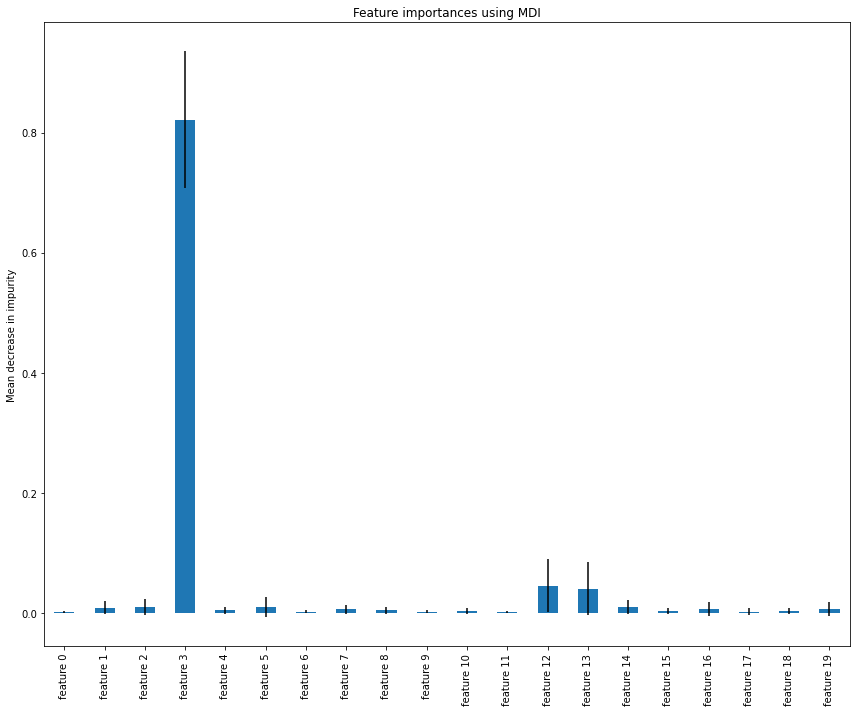

In [ ]:
from sklearn.ensemble import RandomForestClassifier

feature_names = [f"feature {i}" for i in range(df_train[:, :-1].shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(df_train[:, :-1], df_train[:, -1])

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
# featurs from the rf model plus the locations
df_train = df_train[:, [0, 2, 3, 5, 12, 13, 14, 20]]

df_test = df_test[:, [0, 2, 3, 5, 12, 13, 14, 20]]

df_validation = df_validation[:, [0, 2, 3, 5, 12, 13, 14, 20]]

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
reframe_train = pd.DataFrame()
for loc in np.unique(df_train[:, 0]):
    data = df_train[df_train[:, 0]==loc]
    reframe = series_to_supervised(data, 5, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_train = pd.concat([reframe_train, reframe])

reframe_validation = pd.DataFrame()
for loc in np.unique(df_validation[:, 0]):
    data = df_validation[df_validation[:, 0]==loc]
    reframe = series_to_supervised(data, 5, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_validation = pd.concat([reframe_validation, reframe])
    
reframe_test = pd.DataFrame()
for loc in np.unique(df_test[:, 0]):
    data = df_test[df_test[:, 0]==loc]
    reframe = series_to_supervised(data, 5, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_test = pd.concat([reframe_test, reframe])

In [ ]:
values_train = reframe_train.values
values_validation = reframe_validation.values
values_test = reframe_test.values

# split into input and outputs
X_train, X_validation, X_test = values_train[:, :-1], values_validation[:, :-1], values_test[:, :-1]
y_train, y_validation, y_test = values_train[:, -1], values_validation[:, -1], values_test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 5, 8))
X_validation = X_validation.reshape((X_validation.shape[0], 5, 8))
X_test = X_test.reshape((X_test.shape[0], 5, 8))
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(87012, 5, 8) (87012,) (28858, 5, 8) (28858,) (28855, 5, 8) (28855,)


Epoch 1/100
1360/1360 [==============================] - 27s 18ms/step - loss: 0.4134 - accuracy: 0.8209 - val_loss: 0.3926 - val_accuracy: 0.8300
Epoch 2/100
1360/1360 [==============================] - 25s 18ms/step - loss: 0.3735 - accuracy: 0.8404 - val_loss: 0.3847 - val_accuracy: 0.8329
Epoch 3/100
1360/1360 [==============================] - 25s 18ms/step - loss: 0.3711 - accuracy: 0.8405 - val_loss: 0.3846 - val_accuracy: 0.8331
Epoch 4/100
1360/1360 [==============================] - 25s 18ms/step - loss: 0.3692 - accuracy: 0.8409 - val_loss: 0.3812 - val_accuracy: 0.8346
Epoch 5/100
1360/1360 [==============================] - 24s 18ms/step - loss: 0.3689 - accuracy: 0.8412 - val_loss: 0.3802 - val_accuracy: 0.8350
Epoch 6/100
1360/1360 [==============================] - 25s 18ms/step - loss: 0.3675 - accuracy: 0.8413 - val_loss: 0.3787 - val_accuracy: 0.8359
Epoch 7/100
1360/1360 [==============================] - 25s 19ms/step - loss: 0.3665 - accuracy: 0.8420 - val_loss: 0

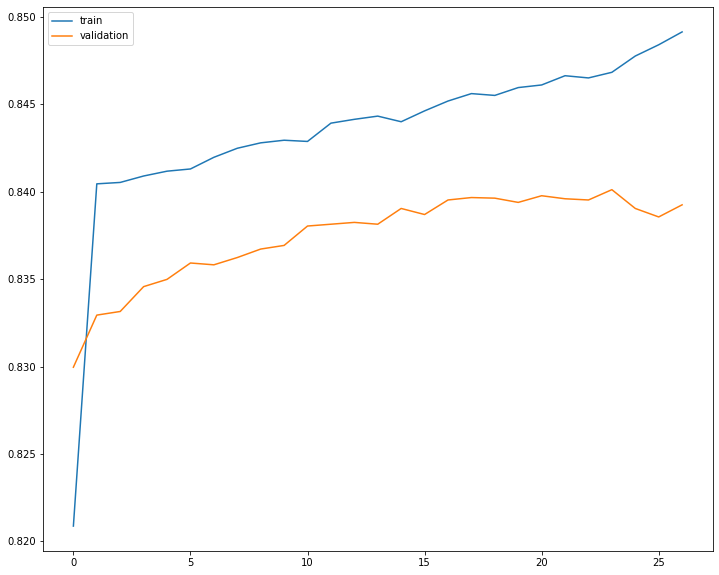

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'))

of_callback = tensorflow.keras.callbacks.EarlyStopping(
                                            monitor='val_accuracy', 
                                            verbose=1,
                                            patience=3,
                                            mode='max',
                                            restore_best_weights=True)
# fit network
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=64,
                    validation_data=(X_validation, y_validation),
                    verbose=1, shuffle=False, callbacks=of_callback)
# plot history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
def label_func(y_pred, threshold):
    predictions = []
    for prob in y_pred:
        if prob <= threshold:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

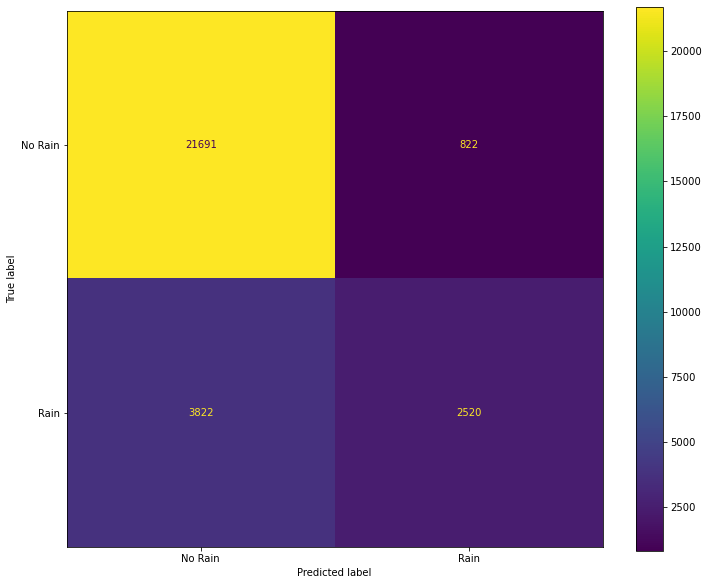

              precision    recall  f1-score   support

     No Rain       0.85      0.96      0.90     22513
        Rain       0.75      0.40      0.52      6342

    accuracy                           0.84     28855
   macro avg       0.80      0.68      0.71     28855
weighted avg       0.83      0.84      0.82     28855



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
predictions = label_func(y_pred, 0.5)

# creating and plotting the confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Rain', 'Rain'])
disp.plot()
plt.show()

# creating classification report
print(classification_report(y_test, predictions, target_names=['No Rain', 'Rain']))

In [ ]:
reframe_train = pd.DataFrame()
for loc in np.unique(df_train[:, 0]):
    data = df_train[df_train[:, 0]==loc]
    reframe = series_to_supervised(data, 3, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_train = pd.concat([reframe_train, reframe])

reframe_validation = pd.DataFrame()
for loc in np.unique(df_validation[:, 0]):
    data = df_validation[df_validation[:, 0]==loc]
    reframe = series_to_supervised(data, 3, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_validation = pd.concat([reframe_validation, reframe])
    
reframe_test = pd.DataFrame()
for loc in np.unique(df_test[:, 0]):
    data = df_test[df_test[:, 0]==loc]
    reframe = series_to_supervised(data, 3, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_test = pd.concat([reframe_test, reframe])

In [ ]:
values_train = reframe_train.values
values_validation = reframe_validation.values
values_test = reframe_test.values

# split into input and outputs
X_train, X_validation, X_test = values_train[:, :-1], values_validation[:, :-1], values_test[:, :-1]
y_train, y_validation, y_test = values_train[:, -1], values_validation[:, -1], values_test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 3, 8))
X_validation = X_validation.reshape((X_validation.shape[0], 3, 8))
X_test = X_test.reshape((X_test.shape[0], 3, 8))
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(87110, 3, 8) (87110,) (28956, 3, 8) (28956,) (28953, 3, 8) (28953,)


Epoch 1/100
1362/1362 [==============================] - 21s 13ms/step - loss: 0.4123 - accuracy: 0.8206 - val_loss: 0.3957 - val_accuracy: 0.8285
Epoch 2/100
1362/1362 [==============================] - 22s 16ms/step - loss: 0.3734 - accuracy: 0.8398 - val_loss: 0.3857 - val_accuracy: 0.8337
Epoch 3/100
1362/1362 [==============================] - 20s 15ms/step - loss: 0.3713 - accuracy: 0.8409 - val_loss: 0.3824 - val_accuracy: 0.8358
Epoch 4/100
1362/1362 [==============================] - 21s 15ms/step - loss: 0.3703 - accuracy: 0.8412 - val_loss: 0.3815 - val_accuracy: 0.8355
Epoch 5/100
1362/1362 [==============================] - 20s 15ms/step - loss: 0.3692 - accuracy: 0.8414 - val_loss: 0.3801 - val_accuracy: 0.8357
Epoch 6/100
1362/1362 [==============================] - 20s 15ms/step - loss: 0.3684 - accuracy: 0.8411 - val_loss: 0.3796 - val_accuracy: 0.8360
Epoch 7/100
1362/1362 [==============================] - 20s 15ms/step - loss: 0.3679 - accuracy: 0.8418 - val_loss: 0

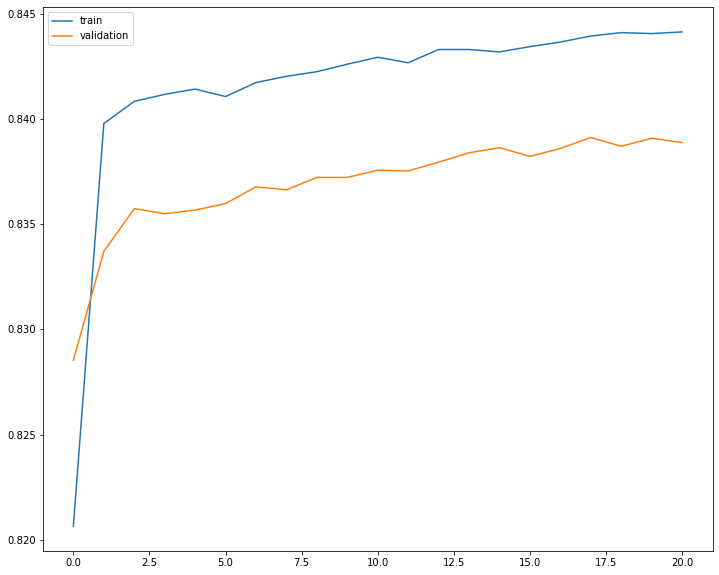

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'))

of_callback = tensorflow.keras.callbacks.EarlyStopping(
                                            monitor='val_accuracy', 
                                            verbose=1,
                                            patience=3,
                                            mode='max',
                                            restore_best_weights=True)
# fit network
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=64,
                    validation_data=(X_validation, y_validation),
                    verbose=1, shuffle=False, callbacks=of_callback)
# plot history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
def label_func(y_pred, threshold):
    predictions = []
    for prob in y_pred:
        if prob <= threshold:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

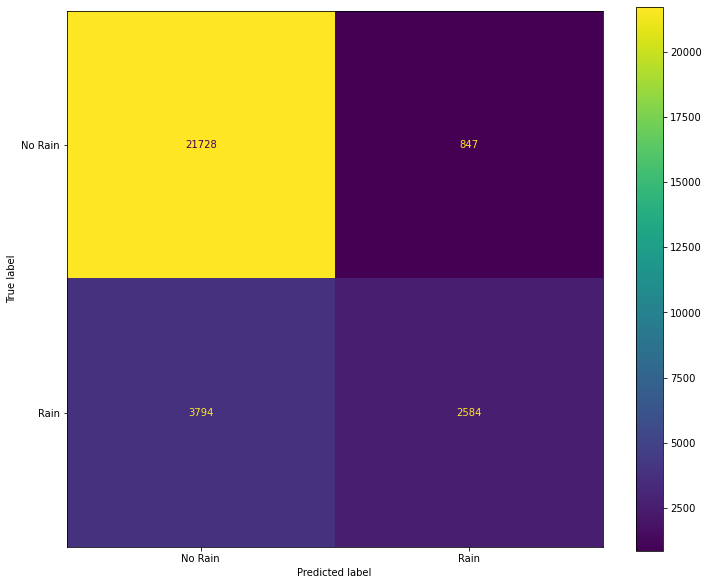

              precision    recall  f1-score   support

     No Rain       0.85      0.96      0.90     22575
        Rain       0.75      0.41      0.53      6378

    accuracy                           0.84     28953
   macro avg       0.80      0.68      0.72     28953
weighted avg       0.83      0.84      0.82     28953



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
predictions = label_func(y_pred, 0.5)

# creating and plotting the confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Rain', 'Rain'])
disp.plot()
plt.show()

# creating classification report
print(classification_report(y_test, predictions, target_names=['No Rain', 'Rain']))

In [ ]:
reframe_train = pd.DataFrame()
for loc in np.unique(df_train[:, 0]):
    data = df_train[df_train[:, 0]==loc]
    reframe = series_to_supervised(data, 10, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_train = pd.concat([reframe_train, reframe])

reframe_validation = pd.DataFrame()
for loc in np.unique(df_validation[:, 0]):
    data = df_validation[df_validation[:, 0]==loc]
    reframe = series_to_supervised(data, 10, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_validation = pd.concat([reframe_validation, reframe])
    
reframe_test = pd.DataFrame()
for loc in np.unique(df_test[:, 0]):
    data = df_test[df_test[:, 0]==loc]
    reframe = series_to_supervised(data, 10, 1)
    reframe = reframe.drop(columns=reframe.columns[-8:-1])
    reframe_test = pd.concat([reframe_test, reframe])

In [ ]:
values_train = reframe_train.values
values_validation = reframe_validation.values
values_test = reframe_test.values

# split into input and outputs
X_train, X_validation, X_test = values_train[:, :-1], values_validation[:, :-1], values_test[:, :-1]
y_train, y_validation, y_test = values_train[:, -1], values_validation[:, -1], values_test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 10, 8))
X_validation = X_validation.reshape((X_validation.shape[0], 10, 8))
X_test = X_test.reshape((X_test.shape[0], 10, 8))
print(X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape)

(86767, 10, 8) (86767,) (28613, 10, 8) (28613,) (28610, 10, 8) (28610,)


Epoch 1/100
1356/1356 [==============================] - 35s 23ms/step - loss: 0.4180 - accuracy: 0.8176 - val_loss: 0.4011 - val_accuracy: 0.8274
Epoch 2/100
1356/1356 [==============================] - 36s 26ms/step - loss: 0.3721 - accuracy: 0.8402 - val_loss: 0.3938 - val_accuracy: 0.8300
Epoch 3/100
1356/1356 [==============================] - 37s 27ms/step - loss: 0.3697 - accuracy: 0.8411 - val_loss: 0.3926 - val_accuracy: 0.8302
Epoch 4/100
1356/1356 [==============================] - 35s 25ms/step - loss: 0.3688 - accuracy: 0.8413 - val_loss: 0.3905 - val_accuracy: 0.8312
Epoch 5/100
1356/1356 [==============================] - 32s 23ms/step - loss: 0.3674 - accuracy: 0.8420 - val_loss: 0.3908 - val_accuracy: 0.8314
Epoch 6/100
1356/1356 [==============================] - 32s 24ms/step - loss: 0.3670 - accuracy: 0.8418 - val_loss: 0.3883 - val_accuracy: 0.8322
Epoch 7/100
1356/1356 [==============================] - 31s 23ms/step - loss: 0.3661 - accuracy: 0.8419 - val_loss: 0

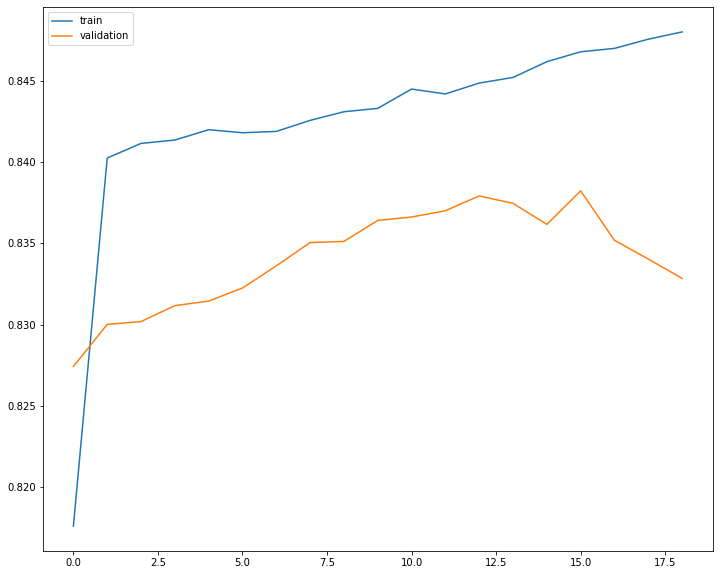

In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

# design network
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=tensorflow.keras.losses.BinaryCrossentropy(),
              optimizer='adam', metrics=tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'))

of_callback = tensorflow.keras.callbacks.EarlyStopping(
                                            monitor='val_accuracy', 
                                            verbose=1,
                                            patience=3,
                                            mode='max',
                                            restore_best_weights=True)
# fit network
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=64,
                    validation_data=(X_validation, y_validation),
                    verbose=1, shuffle=False, callbacks=of_callback)
# plot history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
def label_func(y_pred, threshold):
    predictions = []
    for prob in y_pred:
        if prob <= threshold:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

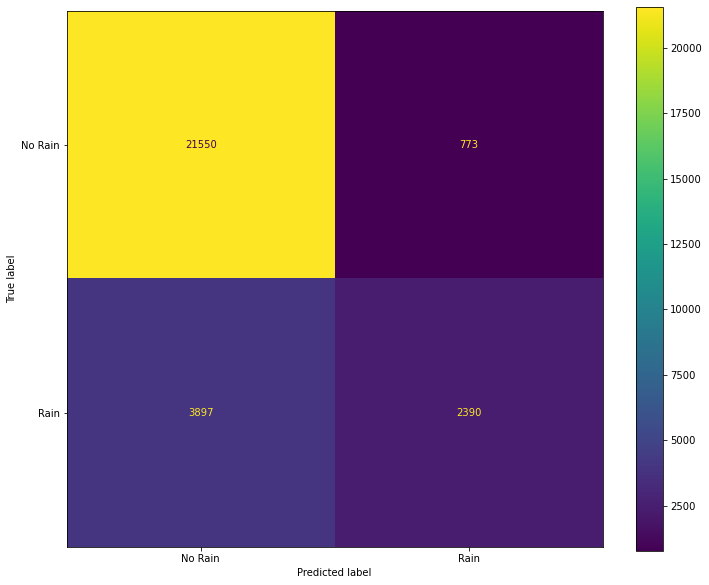

              precision    recall  f1-score   support

     No Rain       0.85      0.97      0.90     22323
        Rain       0.76      0.38      0.51      6287

    accuracy                           0.84     28610
   macro avg       0.80      0.67      0.70     28610
weighted avg       0.83      0.84      0.82     28610



In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
predictions = label_func(y_pred, 0.5)

# creating and plotting the confusion matrix
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Rain', 'Rain'])
disp.plot()
plt.show()

# creating classification report
print(classification_report(y_test, predictions, target_names=['No Rain', 'Rain']))